Epoch 0, Loss: 0.6931
Epoch 50, Loss: 0.0000
Epoch 100, Loss: 0.0000
Epoch 150, Loss: 0.0000
Predictions: ['financial', 'financial', 'financial', 'river', 'river', 'river']


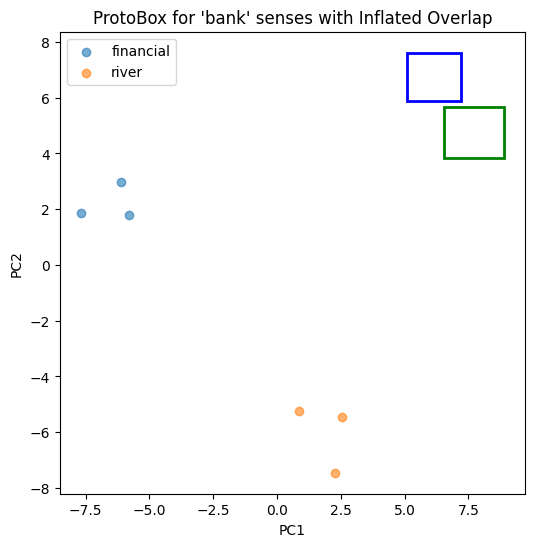

In [34]:
'''
Contextual Box Embeddings (ProtoBox) for Word Sense Disambiguation (WSD)
Applied to senses of the word 'bank'
From scratch implementation in PyTorch, with visualization including a deliberately inflated overlap
'''
# 1. Setup and Imports

# If running in a new environment, uncomment and run:
# !pip install torch transformers matplotlib scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 2. Prepare Data
# We'll create a small toy dataset of sentences containing 'bank' with different senses: 'financial', 'river'

data = [
    ("I deposited money at the bank.", 'financial'),
    ("The bank approved my loan.", 'financial'),
    ("She withdrew cash from the bank ATM.", 'financial'),
    ("The river overflowed its bank after heavy rain.", 'river'),
    ("We sat on the grassy bank and watched the water.", 'river'),
    ("The fisherman cast his line from the bank.", 'river')
]

# Map sense labels to indices
senses = ['financial', 'river']
sense2idx = {s:i for i,s in enumerate(senses)}

# 3. Load BERT for Contextual Embeddings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.eval()

# Function to extract contextual embedding for target word 'bank'
def get_bank_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    with torch.no_grad():
        outputs = bert(**inputs)
    tokens = tokenizer.tokenize(sentence)
    bank_positions = [i for i,t in enumerate(tokens) if t == 'bank']
    if not bank_positions:
        raise ValueError("No 'bank' token in sentence")
    pos = bank_positions[0] + 1
    return outputs.last_hidden_state[0, pos]

# Build dataset embeddings
X = []
y = []
for sent, label in data:
    emb = get_bank_embedding(sent)
    X.append(emb.numpy())
    y.append(sense2idx[label])
X = np.stack(X)
y = np.array(y)

# 4. ProtoBox Model Definition
class ProtoBox(nn.Module):
    def __init__(self, embed_dim, num_senses):
        super().__init__()
        self.c = nn.Parameter(torch.zeros(num_senses, embed_dim))
        # initialize logd to a small positive bias for slightly sized boxes
        self.logd = nn.Parameter(torch.ones(num_senses, embed_dim) * 0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        c = self.c.unsqueeze(0)
        d = torch.exp(self.logd).unsqueeze(0)
        lo = c - d
        hi = c + d
        inside = torch.relu(torch.min(x - lo, hi - x))
        score = inside.sum(dim=-1)
        return score

# 5. Training

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ProtoBox(embed_dim=X.shape[1], num_senses=len(senses)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

tensor_X = torch.tensor(X, dtype=torch.float32).to(device)
tensor_y = torch.tensor(y, dtype=torch.long).to(device)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    scores = model(tensor_X)
    loss = criterion(scores, tensor_y)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 6. Inference
model.eval()
with torch.no_grad():
    scores = model(tensor_X)
    preds = scores.argmax(dim=1).cpu().numpy()
    print("Predictions:", [senses[p] for p in preds])

# 7. Visualization with Inflated Overlap
# We'll inflate the learned deltas to guarantee an overlap for illustration
inflation_factor = 1.5
pca = PCA(n_components=2)
all_centers = model.c.detach().cpu().numpy()
all_points = X
pca.fit(np.vstack([all_centers, all_points]))
centers_2d = pca.transform(all_centers)
points_2d = pca.transform(all_points)

# Extract and inflate deltas
raw_d = torch.exp(model.logd).detach().cpu().numpy()
inflated_d = raw_d * inflation_factor

# Compute 2D boundaries for each sense
boundaries = []
for i in range(len(senses)):
    delta_2d = pca.components_[:2] @ inflated_d[i]
    lo = centers_2d[i] - delta_2d
    hi = centers_2d[i] + delta_2d
    boundaries.append((lo, hi))

# Plot
plt.figure(figsize=(6,6))
colors = ['blue', 'green']
for i in range(len(senses)):
    pts = points_2d[y==i]
    plt.scatter(pts[:,0], pts[:,1], label=senses[i], alpha=0.6)
# Draw inflated boxes and overlap region
lo1, hi1 = boundaries[0]
lo2, hi2 = boundaries[1]
for i,(lo, hi) in enumerate(boundaries):
    rect = plt.Rectangle(lo, hi[0]-lo[0], hi[1]-lo[1], fill=False, edgecolor=colors[i], linewidth=2)
    plt.gca().add_patch(rect)
# Compute overlap
lo_o = np.maximum(lo1, lo2)
hi_o = np.minimum(hi1, hi2)
if np.all(lo_o < hi_o):
    w, h = hi_o - lo_o
    overlap_rect = plt.Rectangle(lo_o, w, h, color='red', alpha=0.3, label='overlap')
    plt.gca().add_patch(overlap_rect)

plt.legend()
plt.title("ProtoBox for 'bank' senses with Inflated Overlap")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
